In [11]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

import warnings
warnings.filterwarnings("ignore")


In [2]:
mt_reads_share = pd.read_csv("../data/share/mapped_reads_stats.tsv", sep="\s\s")
mt_reads_share["mapped_reads"] = mt_reads_share["mapped_reads"].str.removesuffix("%").astype(float)
mt_reads_share["sample"] = mt_reads_share["sample"].str.extract("Kgd-mtDNA-(S\d\d)")
mt_reads_share.head(2)

,sample,mapped_reads
0,S01,5.36
1,S02,3.71


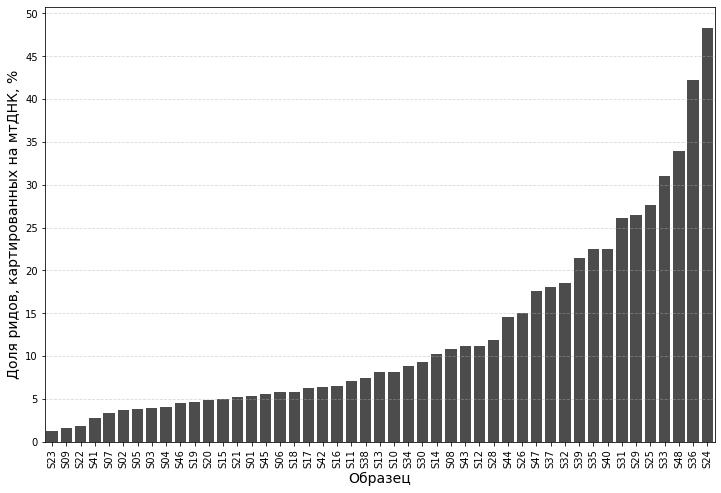

In [37]:
plt.figure(figsize=(12, 8))
sns.barplot(data=mt_reads_share.sort_values("mapped_reads"), x="sample", y="mapped_reads", color="black", alpha=.7)
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 51, 5))
plt.ylabel("Доля ридов, картированных на мтДНК, %", fontsize=14)
plt.xlabel("Образец", fontsize=14)
plt.grid(alpha=0.5, axis="y", linestyle='--')
plt.savefig("../figures/mt_mapped_reads.png")
plt.show()

In [3]:
path_to_depth = "../data/interim/depth.tsv"
depth = pd.read_csv(path_to_depth, sep="\t")
depth.columns = depth.columns.str.removeprefix("data/interim/mapping/")
print(depth.shape)
depth.head(2)

(16569, 49)


,#CHROM,POS,Kgd-mtDNA-S01.bam,Kgd-mtDNA-S02.bam,Kgd-mtDNA-S03.bam,Kgd-mtDNA-S04.bam,Kgd-mtDNA-S05.bam,Kgd-mtDNA-S06.bam,Kgd-mtDNA-S07.bam,Kgd-mtDNA-S08.bam,...,Kgd-mtDNA-S39.bam,Kgd-mtDNA-S40.bam,Kgd-mtDNA-S41.bam,Kgd-mtDNA-S42.bam,Kgd-mtDNA-S43.bam,Kgd-mtDNA-S44.bam,Kgd-mtDNA-S45.bam,Kgd-mtDNA-S46.bam,Kgd-mtDNA-S47.bam,Kgd-mtDNA-S48.bam
0,NC_012920.1,1,193,64,88,121,288,180,128,190,...,389,650,36,56,83,196,16,59,255,370
1,NC_012920.1,2,194,64,91,119,287,180,135,196,...,399,656,38,59,87,206,16,58,253,371


In [20]:
depth_melted = depth.melt("POS", depth.columns[2:], "Sample", "Depth")
depth_melted["Sample"] = depth_melted["Sample"].str.extract("Kgd-mtDNA-(S\d\d)\.bam")
samples_sorted = depth_melted.groupby("Sample").Depth.mean().sort_values().index.values
incorrect_pos = depth.set_index("POS").mean(axis=1).argmin() + 1
incorrect_pos

3106

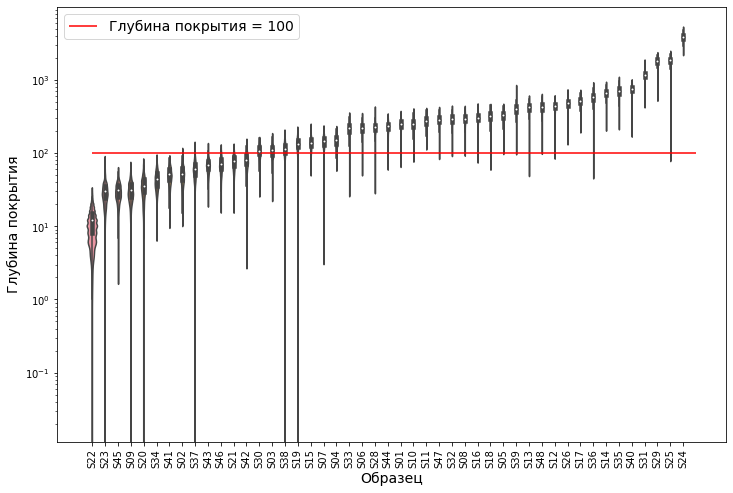

In [49]:
_dcov = 100
plt.figure(figsize=(12, 8))
sns.violinplot(data=depth_melted[depth_melted.POS != incorrect_pos], y="Depth", x="Sample", order=samples_sorted)
plt.yscale("log")
plt.hlines([_dcov], 0, 47, "r", label=f"Глубина покрытия = {_dcov}")
plt.xticks(rotation=90)
plt.ylabel("Глубина покрытия", fontsize=14)
plt.xlabel("Образец", fontsize=14)
plt.legend(fontsize=14)
plt.savefig("../figures/sample_cov_depth.png")
plt.show()

In [31]:
depth_stats = depth_melted[depth_melted.POS != incorrect_pos].groupby("Sample").Depth.describe().sort_values("mean")
depth_stats.index = depth_stats.index.str.removesuffix(".bam")
depth_stats

,count,mean,std,min,25%,50%,75%,max
Sample,,,,,,,,
S22,16568.0,11.861782,5.450964,1.0,8.0,12.0,15.0,32.0
S23,16568.0,30.474469,9.715862,0.0,24.0,30.0,36.0,87.0
S45,16568.0,31.028911,8.262734,4.0,25.0,31.0,37.0,62.0
S09,16568.0,31.784042,9.726244,0.0,25.0,31.0,38.0,72.0
S20,16568.0,37.015934,11.549118,1.0,29.0,36.0,44.0,80.0
S34,16568.0,45.761649,12.720512,10.0,36.0,44.0,54.0,92.0
S41,16568.0,51.397936,12.242562,13.0,43.0,51.0,60.0,90.0
S02,16568.0,53.107436,13.801293,14.0,43.0,52.0,62.0,114.0
S37,16568.0,61.716985,16.271498,4.0,50.0,60.0,72.0,136.0


In [32]:
(depth_stats["mean"] > 250).sum()

22

In [33]:
22 / 47

0.46808510638297873

In [ ]:
# merged = pd.merge(depth_stats, mt_reads_share.set_index("sample"), left_index=True, right_index=True)
# merged.drop("count", axis=1).to_csv("../data/share/depth.csv")

In [7]:
merged = pd.read_csv("../data/share/depth.csv", index_col=0)
merged.head()

,mean,std,min,25%,50%,75%,max,mapped_reads
S22,11.861782,5.450964,1.0,8.0,12.0,15.0,32.0,1.86
S23,30.474469,9.715862,0.0,24.0,30.0,36.0,87.0,1.29
S45,31.028911,8.262734,4.0,25.0,31.0,37.0,62.0,5.55
S09,31.784042,9.726244,0.0,25.0,31.0,38.0,72.0,1.64
S20,37.015934,11.549118,1.0,29.0,36.0,44.0,80.0,4.83


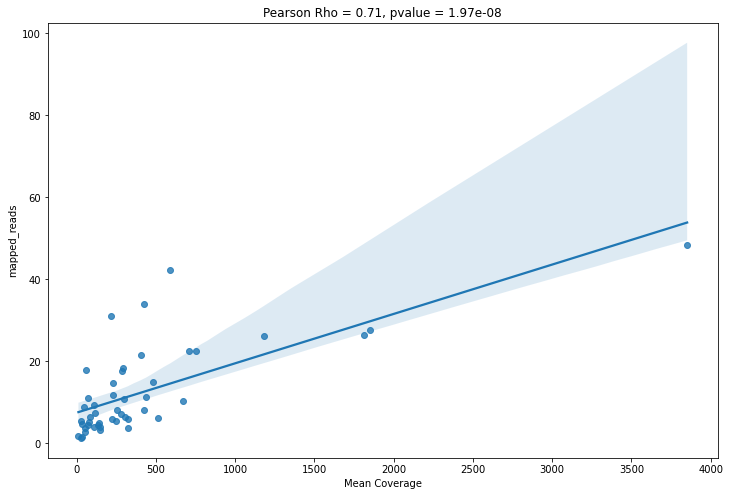

In [17]:
plt.figure(figsize=(12, 8))
sns.regplot(data=merged, x="mean", y="mapped_reads")
plt.xlabel("Mean Coverage")
rho, pval = stats.pearsonr(merged["mean"], merged["mapped_reads"])
plt.title(f"Pearson Rho = {rho:.2f}, pvalue = {pval:.2e}")
plt.show()

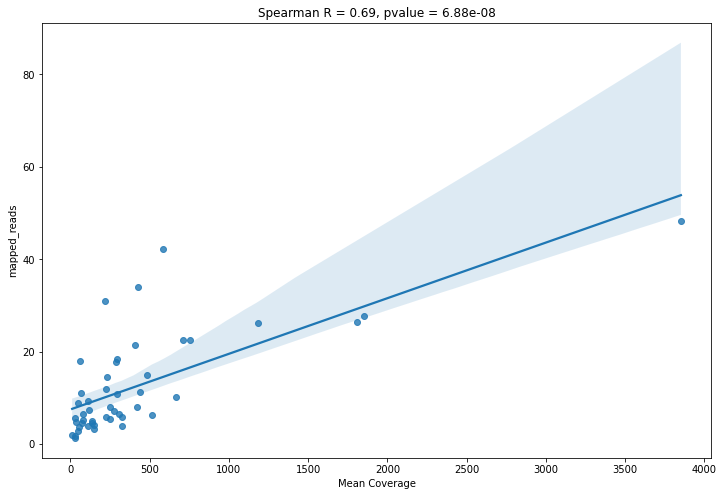

In [18]:
plt.figure(figsize=(12, 8))
sns.regplot(data=merged, x="mean", y="mapped_reads")
plt.xlabel("Mean Coverage")
rho, pval = stats.spearmanr(merged["mean"], merged["mapped_reads"])
plt.title(f"Spearman R = {rho:.2f}, pvalue = {pval:.2e}")
plt.show()

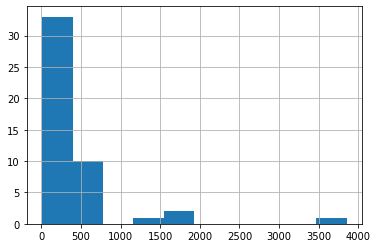

In [8]:
merged["mean"].hist();

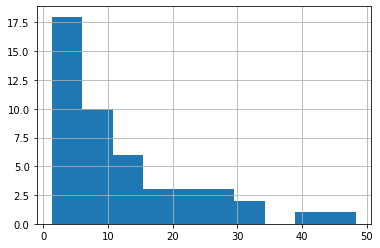

In [43]:
merged["mapped_reads"].hist();

In [46]:
merged.mapped_reads.describe()

count    47.000000
mean     12.389787
std      10.958982
min       1.290000
25%       4.930000
50%       8.090000
75%      17.830000
max      48.350000
Name: mapped_reads, dtype: float64

In [ ]:
fig = px.line(depth_melted[depth_melted.POS != incorrect_pos], x="POS", y="Depth", color='Sample', title="Coverage", height=600, category_orders={"Sample": samples_sorted[::-1]})
fig.show()